## Построение корреляционной матрицы экспресии группы белков Polycomb-Targets-Transription_factors

In [1]:
#импорт необходимых библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import scanpy as sc
import scanpy.external as sce
import symphonypy as sp
import seaborn as sns
from CSCORE import CSCORE

In [2]:
#закружаем датасет 
tf_list = list(pd.read_csv('../data/GO_TF_set.txt', header=None)[0]) #список транскрипционных факторов
targets_list = list(pd.read_csv('../data/tf_targets.csv', header=None)[0]) #список таргетов
polycomb_genes = pd.read_csv('../data/Polycomb_proteins.csv') #список генов поликомба

In [3]:
# проверка длин всех списков
len(tf_list), len(targets_list), len(polycomb_genes)

(203, 664, 54)

In [4]:
#проверка длины общего списка
poly_C_TF_target_not_Ensembl = tf_list + targets_list + list(polycomb_genes.Name)
len(poly_C_TF_target_not_Ensembl)

921

## Предобработка данных single-sell dataset Human Brain Cell Atlas v1.0 

In [5]:
# Загрузка данных Human Brain Cell Atlas v1.0 (https://cellxgene.cziscience.com/collections/283d65eb-dd53-496d-adb7-7570c7caa443)
adata = sc.read('../data/sc_RNA_brain.h5ad')
adata.raw = adata #сохраняем аттрибут raw для остальных данных

In [6]:
#отбор по количеству клеток и экспрессируемых генов
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [7]:
#фильтрация по интересующим генам
adata_select_all_not_Ens = adata[:, adata.var['Gene'].isin(poly_C_TF_target_not_Ensembl)].copy()
adata_select_all_not_Ens

AnnData object with n_obs × n_vars = 107301 × 620
    obs: 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'supercluster_term', 'cluster_id', 'subcluster_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells'
    uns: 'batch_condition', 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_UMAP', 'X_tSNE'

In [8]:
#нормализация данных
sc.pp.normalize_total(adata_select_all_not_Ens, target_sum=1e4)
sc.pp.log1p(adata_select_all_not_Ens)

In [9]:
# просмотр всех фичей слоев полученной adata
adata_select_all_not_Ens

AnnData object with n_obs × n_vars = 107301 × 620
    obs: 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'supercluster_term', 'cluster_id', 'subcluster_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells'
    uns: 'batch_condition', 'citation', 'schema_reference', 'schema_version', 'title', 'log1p'
    obsm: 'X_UMAP', 'X_tSNE'

In [10]:
# создаем лист индексов и лист имет отсртированных генов для CSCORE
gene_indexes = list(range(len(adata_select_all_not_Ens.var_names)))
gene_names = list(adata_select_all_not_Ens.var['Gene'])
gene_names.__len__()

620

In [11]:
# расчет корреляционной матрицы CSCORE
res = CSCORE(adata_select_all_not_Ens, gene_indexes)

IRLS converged after 6 iterations.
14 among 620 genes have negative variance estimates. Their co-expressions with other genes were set to 0.
0.0926% co-expression estimates were greater than 1 and were set to 1.
0.0151% co-expression estimates were greater than 1 and were set to 1.


In [12]:
# сохраняем матрицу корреляции
corr_df = pd.DataFrame(res[0], index = gene_names, columns = gene_names) 
corr_df.to_csv('gene_correlation_matrix_CSCORE_names.csv', index=True)

In [17]:
# считывание готовой матрицы 
corr_df1 = pd.read_csv('../data/gene_correlation_matrix_CSCORE_names.csv', index_col=0)
corr_df1

,SP9,CCND1,FEZF2,DLX1,ABCB11,ERG,ONECUT1,CAV1,F2R,PROM1,...,GFI1,CD40LG,SIX3,CD6,GATA3,ICAM3,IFNG,HOXB2,IL2RB,BLK
SP9,1.000000,0.739561,0.0,0.006881,-0.028957,-0.048833,0.137148,-0.002077,0.216693,0.073763,...,-0.106265,-0.040111,-0.051302,-0.186859,0.0,-0.058033,0.028919,-0.019230,-0.087078,0.0
CCND1,0.739561,1.000000,0.0,0.146760,1.000000,0.034552,0.530108,0.113341,0.591463,0.429646,...,-0.133905,0.002383,-0.018991,-0.155790,0.0,-0.037968,-0.031549,0.190198,-0.094820,0.0
FEZF2,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
DLX1,0.006881,0.146760,0.0,1.000000,0.051013,-0.026167,0.005365,-0.020790,0.005230,0.090176,...,-0.066646,-0.041601,-0.033447,0.017595,0.0,-0.022818,-0.013840,-0.040967,-0.056543,0.0
ABCB11,-0.028957,1.000000,0.0,0.051013,1.000000,-0.026340,0.114778,-0.007541,-0.012763,0.101846,...,-0.018628,0.024731,0.012536,0.323039,0.0,0.265084,0.031467,0.026649,-0.028475,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICAM3,-0.058033,-0.037968,0.0,-0.022818,0.265084,0.009342,-0.018902,0.078359,0.018524,0.045657,...,-0.003456,0.086730,0.027702,0.398638,0.0,1.000000,0.048867,0.089824,0.007416,0.0
IFNG,0.028919,-0.031549,0.0,-0.013840,0.031467,-0.007471,-0.005837,-0.004884,-0.022748,-0.028353,...,0.015706,-0.005764,0.039235,0.055244,0.0,0.048867,1.000000,0.015352,0.133084,0.0
HOXB2,-0.019230,0.190198,0.0,-0.040967,0.026649,-0.042454,-0.009163,0.129587,-0.036792,-0.030085,...,-0.046993,0.069561,-0.046208,-0.001023,0.0,0.089824,0.015352,1.000000,-0.066867,0.0
IL2RB,-0.087078,-0.094820,0.0,-0.056543,-0.028475,0.280035,0.013322,-0.006084,-0.046382,0.045968,...,0.501112,0.105425,0.121787,0.003621,0.0,0.007416,0.133084,-0.066867,1.000000,0.0


In [18]:
# задание цветовых меток для разных классов генов 
gene_groups = []
gene_order = []  # This will determine the order of genes in the plot

# First add TFs
for gene in corr_df1.columns:
    if gene in tf_list:
        gene_groups.append('TF')
        gene_order.append((gene, 'TF'))
        
# Then add Targets
for gene in corr_df1.columns:
    if gene not in tf_list and gene not in list(polycomb_genes.Name):
        gene_groups.append('Target')
        gene_order.append((gene, 'Target'))
        
# Finally add Polycomb genes
for gene in corr_df1.columns:
    if gene in list(polycomb_genes.Name) and gene not in tf_list:
        gene_groups.append('Polycomb')
        gene_order.append((gene, 'Polycomb'))

# Extract just the gene names in order
sorted_genes = [gene for gene, group in gene_order]

# Reorder the correlation matrix
sorted_corr_df = corr_df1.loc[sorted_genes, sorted_genes]

# 2. Create the palette
palette = {
    'Polycomb': '#1f77b4',  
    'TF': '#d62728',        
    'Target': '#2ca02c'     
}

row_colors = [palette[group] for gene, group in gene_order]
col_colors = row_colors.copy()

<Figure size 6000x6000 with 0 Axes>

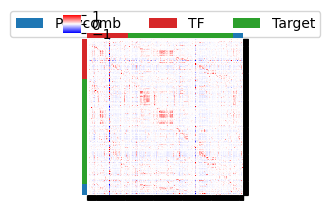

In [19]:
# детализированная матрица
plt.figure(figsize=(60, 60))  

g = sns.clustermap(
    sorted_corr_df,
    cmap='bwr',
    center=0,
    row_colors=row_colors,
    col_colors=col_colors,
    figsize=(60, 60),
    dendrogram_ratio=0.1,
    cbar_pos=(0.02, 0.8, 0.05, 0.18),
    row_cluster=False,
    col_cluster=False,
    yticklabels=True,
    xticklabels=True,
)

plt.setp(
    g.ax_heatmap.get_xticklabels(),
    rotation=90,
    fontsize=4,          
    ha='right',
    va='top',
    rotation_mode='anchor'  
)

plt.setp(
    g.ax_heatmap.get_yticklabels(),
    fontsize=4,
    va='center'         
)


g.ax_heatmap.tick_params(axis='both', which='both', pad=2)

g.ax_heatmap.figure.subplots_adjust(
    left=0.3,          
    right=0.9,
    bottom=0.3,         
    top=0.9
)


for label in palette:
    g.ax_col_dendrogram.bar(0, 0, color=palette[label], label=label)
g.ax_col_dendrogram.legend(loc='center', ncol=3)

plt.savefig(
    "coexpression_all_labels.pdf",
    dpi=600,            
    bbox_inches='tight',
    format='pdf',
    metadata={'CreationDate': None}  )

# компактная версия
g.fig.set_size_inches(3, 3)
g.ax_heatmap.set_xticklabels([])  # Отключаем подписи для компактной версии
g.ax_heatmap.set_yticklabels([])
g.savefig("coexpression_compact_CSCORE.png", dpi=200)

In [20]:
threshold = 0.5

# Создаем бинарную матрицу (1 - значимая корреляция, 0 - незначимая)
significant_correlations = (corr_df1.abs() > threshold).astype(int)

# Считаем количество значимых корреляций для каждого гена
significant_counts = significant_correlations.sum(axis=1) - 1  # вычитаем корреляцию с самим собой

# Сортируем гены по убыванию количества значимых корреляций
gene_counts = significant_counts.sort_values(ascending=False)

# Выбираем топ-N генов (топ-100)
top_n = 50
top_connected_genes = gene_counts.head(top_n)

In [21]:
list(top_connected_genes.index)

['LHX8',
 'AFP',
 'EPO',
 'EMX2',
 'RBBP7',
 'CCND1',
 'LHX2',
 'SATB2',
 'PAX2',
 'GATA4',
 'BIRC5',
 'CD8B',
 'CDX2',
 'CLDN7',
 'CDH17',
 'CASP7',
 'STIM1',
 'CYP7A1',
 'PDGFA',
 'PAK1',
 'APC',
 'PGR',
 'SULT2A1',
 'BCL2',
 'GFER',
 'FCGR3B',
 'ATM',
 'ELANE',
 'TFAP2D',
 'MITF',
 'ACAT2',
 'MUC2',
 'JUND',
 'NKX3-1',
 'KLF9',
 'FOXA1',
 'PITX2',
 'CD34',
 'CD8A',
 'S100B',
 'DMRT1',
 'UBE2I',
 'PPARA',
 'MUC5AC',
 'DSG4',
 'NF1',
 'SELE',
 'PHC2',
 'CTNNB1',
 'IRX3']

In [22]:
type_list = []
for gene in list(top_connected_genes.index):
    if gene in tf_list:
        type_list.append('TF')
    elif gene in polycomb_genes:
        type_list.append('polycomb')
    else: type_list.append('target')

In [23]:
top_genes = pd.DataFrame(data = {
    'gene' : list(top_connected_genes.index),
    'counts' : list(top_connected_genes.values),
    'type' : type_list
})

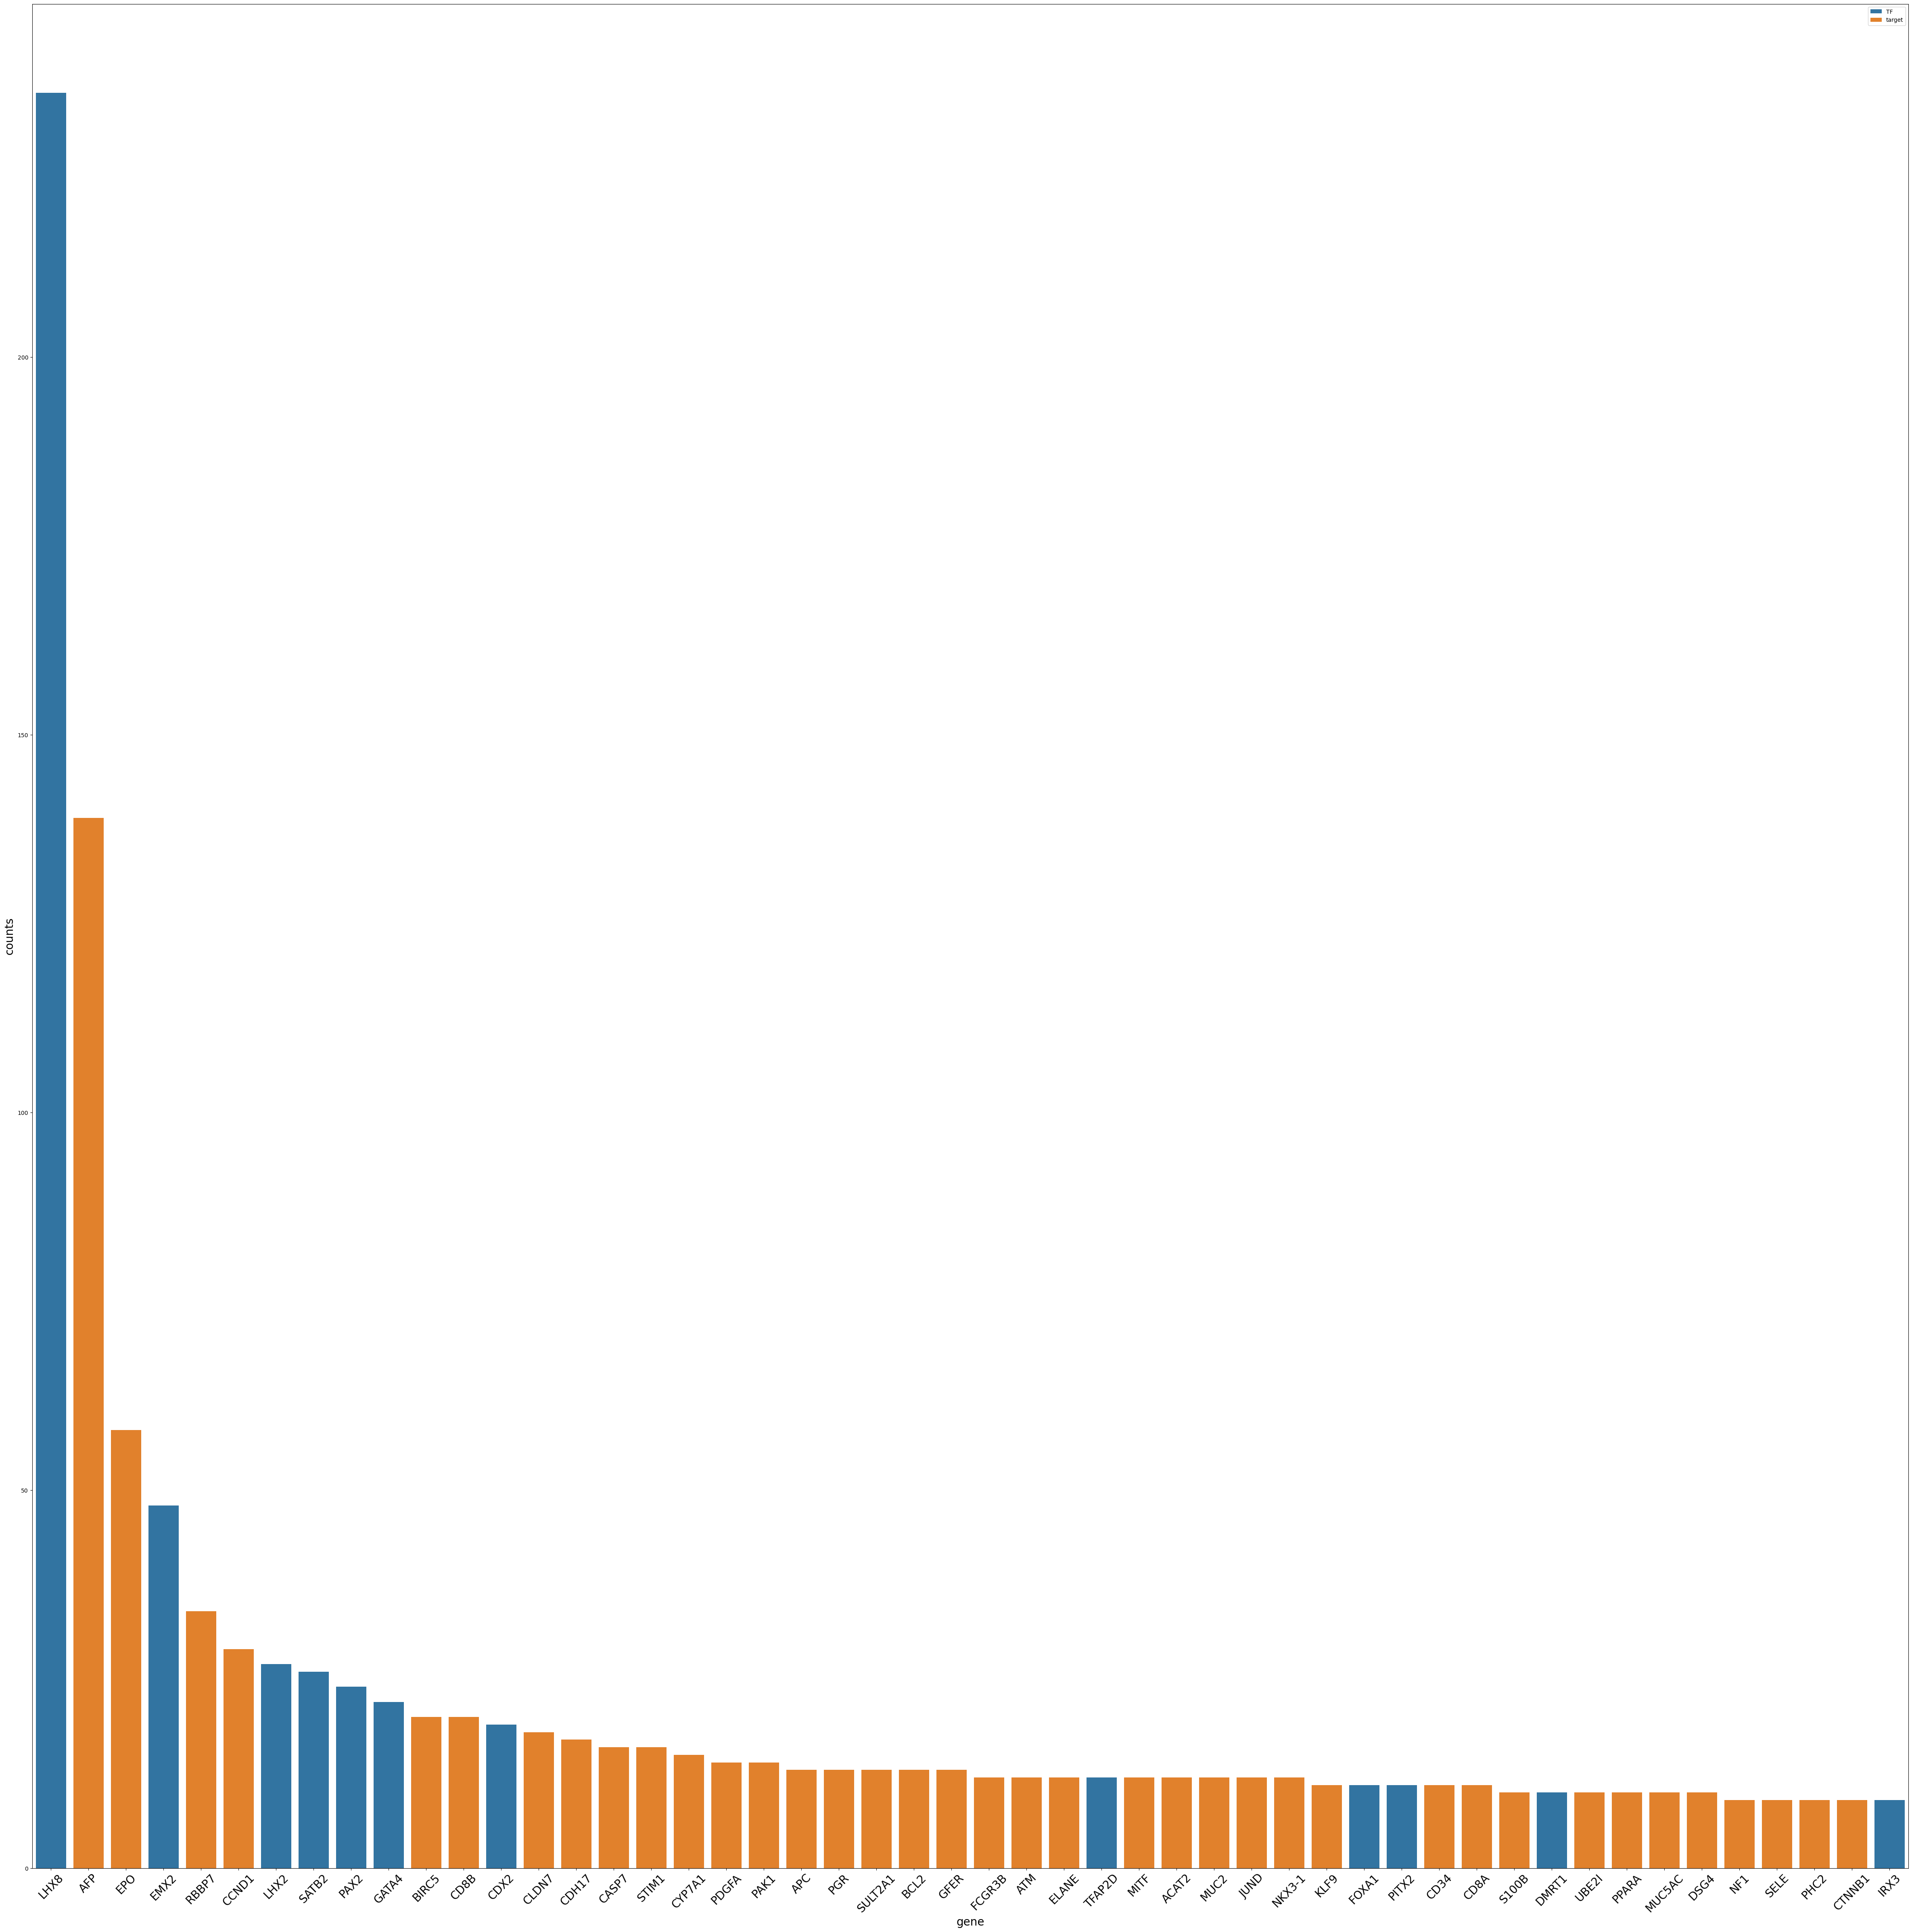

In [24]:
plt.figure(figsize=(60, 60))  
sns.barplot(top_genes, x = 'gene', y = 'counts', hue  = 'type')
plt.legend(title="Тип гена", loc="upper right",  title_fontsize=14, fontsize=100)
plt.xticks(rotation=45, fontsize = 15)
plt.xticks(fontsize = 20)
plt.xlabel(xlabel='gene',fontsize = 20)
plt.ylabel(ylabel='counts', fontsize = 20)
plt.legend()
plt.savefig("top_genes.png", dpi=200)
None